## Save the necessary files

In [1]:
import pandas as pd
import numpy as np
import time
import gc
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
from sklearn import model_selection, metrics
from sklearn.metrics import mean_squared_error, r2_score
# from s3fs.core import S3FileSystem

def global_map_plot(df, variable, vmin, vmax, cmap, title):
    # get new coordinate
    df["lon_new"] = np.where(df['lon'] <= 180, df['lon'], df['lon']-360)

    plt.figure(figsize=(18, 12))
    map = Basemap()
    map.drawcoastlines()
    map.drawstates()
    map.drawcountries()
    map.drawmeridians(range(0, 360, 30),labels=[True,False,False,True],fontsize=20)
    map.drawparallels(range(-90, 100, 30), labels=[True,False,False,True],fontsize=20)
    if cmap == "bwr":
        map.fillcontinents(zorder=0)
    plt.scatter(df["lon_new"], df["lat"], 
                c=df[variable],
                s=6, cmap=cmap, vmin=vmin, vmax=vmax)
    clb = plt.colorbar(orientation="vertical",fraction = 0.023, pad=0.01)
    clb.ax.tick_params(labelsize=20)
    #plt.colorbar(orientation="horizontal",fraction=0.046, pad=0.1)
    plt.savefig("./"+title+"_rmse.pdf")
    plt.show()

In [2]:
# s3 = S3FileSystem()
validation_path = "/glade/scratch/zhonghua/CESM_validation_min/"
save_dir = "/glade/scratch/zhonghua/model-validation_min/"

def workflow(start_year, validation_path, save_dir):
    rmse_by_lat_lon_ls = []
    rmse_by_lat_lon_overall_ls = []
    rmse_overall_ls = []
    pcc_by_lat_lon_ls = []
    pcc_by_lat_lon_overall_ls = []
    pcc_overall_ls = []
    
    for i in range(2,34):
        member = (str(i).zfill(3))
        print("member:",member)
        t_0 = time.time()
        df=pd.read_csv(validation_path+start_year+"/"+member+"_ens.csv")
        print("It took", time.time()-t_0, "to load csv")
        
        t_1 = time.time()
        rmse_by_lat_lon = df.groupby(["lat","lon"])\
                           .apply(lambda df: np.sqrt(mean_squared_error(df["TREFMNAV_U"],
                                                                        df[member])))
        rmse_by_lat_lon_ls.append(rmse_by_lat_lon)
        
        pcc_by_lat_lon = df.groupby(["lat","lon"])\
                           .apply(lambda df: r2_score(df["TREFMNAV_U"],
                                                      df[member]))
        pcc_by_lat_lon_ls.append(pcc_by_lat_lon)
        
        
        # calculate the rmse groupped by lat/lon first, then calcuate the mean of overall gridcell
        rmse_by_lat_lon_overall = rmse_by_lat_lon.mean()
        rmse_by_lat_lon_overall_ls.append(rmse_by_lat_lon_overall)
        #print("Mean of rmse groupped by lat/lon is:", rmse_by_lat_lon_mean)
        
        # calcuate the mean of all gridcell directly (regardless of lat/lon)
        rmse_overall = np.sqrt(mean_squared_error(df["TREFMNAV_U"],df[member]))
        rmse_overall_ls.append(rmse_overall)
        #print("Overall rmse without groupby is:", rmse_overall)
        
        
        # calculate the pcc groupped by lat/lon first, then calcuate the mean of overall gridcell
        pcc_by_lat_lon_overall = pcc_by_lat_lon.mean()
        pcc_by_lat_lon_overall_ls.append(pcc_by_lat_lon_overall)
        #print("Mean of pcc groupped by lat/lon is:", pcc_by_lat_lon_mean)

        # calcuate the mean of all gridcell directly (regardless of lat/lon)
        pcc_overall = r2_score(df["TREFMNAV_U"],df[member])
        pcc_overall_ls.append(pcc_overall)
        #print("Overall pcc without groupby is:", pcc_overall)
        
        del df, rmse_by_lat_lon, rmse_by_lat_lon_overall, rmse_overall
        del pcc_by_lat_lon, pcc_by_lat_lon_overall, pcc_overall
        gc.collect()
        print("It took", time.time()-t_1, "to finish",member)
        print("\n")
    
    print("rmse by lat/lon")
    rmse_by_lat_lon=pd.concat(rmse_by_lat_lon_ls,axis=1)
    print("shape of rmse by lat/lon",rmse_by_lat_lon.shape)
    rmse_by_lat_lon.to_csv(save_dir+start_year+"/rmse_by_lat_lon.csv")
    del rmse_by_lat_lon_ls
    gc.collect()
    print("\n")
    
    print("mean of rmse by lat/lon")
    rmse_by_lat_lon_mean = rmse_by_lat_lon.mean(axis=1)
    display(rmse_by_lat_lon_mean.describe())
    rmse_by_lat_lon_mean.to_csv(save_dir+start_year+"/rmse_by_lat_lon_mean.csv")
    del rmse_by_lat_lon
    gc.collect()
    print("\n")
    
    print("mean of mean of overall gridcell")
    rmse_by_lat_lon_overall=np.asarray(rmse_by_lat_lon_overall_ls)
    print("mean:",rmse_by_lat_lon_overall.mean())
    np.savetxt("./"+start_year+"/rmse_by_lat_lon_overall.txt",rmse_by_lat_lon_overall)
    del rmse_by_lat_lon_overall, rmse_by_lat_lon_overall_ls
    gc.collect()
    print("\n")
    
    print("mean of overall gridcell")
    rmse_overall=np.asarray(rmse_overall_ls)
    print("mean:",rmse_overall.mean())
    np.savetxt("./"+start_year+"/rmse_overall.txt",rmse_overall)
    del rmse_overall, rmse_overall_ls
    gc.collect()
    print("\n")
    
    print("pcc by lat/lon")
    pcc_by_lat_lon=pd.concat(pcc_by_lat_lon_ls,axis=1)
    print("shape of pcc by lat/lon",pcc_by_lat_lon.shape)
    pcc_by_lat_lon.to_csv(save_dir+start_year+"/pcc_by_lat_lon.csv")
    del pcc_by_lat_lon_ls
    gc.collect()
    print("\n")
    
    print("mean of pcc by lat/lon")
    pcc_by_lat_lon_mean = pcc_by_lat_lon.mean(axis=1)
    display(pcc_by_lat_lon_mean.describe())
    pcc_by_lat_lon_mean.to_csv(save_dir+start_year+"/pcc_by_lat_lon_mean.csv")
    del pcc_by_lat_lon
    gc.collect()
    print("\n")
    
    print("mean of mean of overall gridcell")
    pcc_by_lat_lon_overall=np.asarray(pcc_by_lat_lon_overall_ls)
    print("mean:",pcc_by_lat_lon_overall.mean())
    np.savetxt("./"+start_year+"/pcc_by_lat_lon_overall.txt",pcc_by_lat_lon_overall)
    del pcc_by_lat_lon_overall, pcc_by_lat_lon_overall_ls
    gc.collect()
    print("\n")
    
    print("mean of overall gridcell")
    pcc_overall=np.asarray(pcc_overall_ls)
    print("mean:",pcc_overall.mean())
    np.savetxt("./"+start_year+"/pcc_overall.txt",pcc_overall)
    del pcc_overall, pcc_overall_ls
    gc.collect()
    print("\n")
    
    return rmse_by_lat_lon_mean

## Save the necessary files

### 2006

In [3]:
start_year = "2006"
df_2006 = workflow(start_year, validation_path, save_dir)

member: 002
It took 8.176903247833252 to load csv
It took 8.207740306854248 to finish 002


member: 003
It took 8.148770809173584 to load csv
It took 8.16732120513916 to finish 003


member: 004
It took 8.156179666519165 to load csv
It took 8.195486545562744 to finish 004


member: 005
It took 8.172335863113403 to load csv
It took 8.200872421264648 to finish 005


member: 006
It took 8.138054609298706 to load csv
It took 8.172953844070435 to finish 006


member: 007
It took 8.16562795639038 to load csv
It took 8.193695783615112 to finish 007


member: 008
It took 8.15504503250122 to load csv
It took 8.143985748291016 to finish 008


member: 009
It took 8.155457973480225 to load csv
It took 8.213387250900269 to finish 009


member: 010
It took 8.174542903900146 to load csv
It took 8.16519546508789 to finish 010


member: 011
It took 8.151626586914062 to load csv
It took 8.161765575408936 to finish 011


member: 012
It took 8.15264892578125 to load csv
It took 8.174637079238892 to finish

count    4439.000000
mean        0.752928
std         0.305529
min         0.105164
25%         0.543050
50%         0.742037
75%         0.940353
max         1.937255
dtype: float64



mean of mean of overall gridcell
mean: 0.7529277624997444


mean of overall gridcell
mean: 0.8128120702523769


pcc by lat/lon
shape of pcc by lat/lon (4439, 32)


mean of pcc by lat/lon


count    4439.000000
mean        0.967457
std         0.038675
min         0.737257
25%         0.963800
50%         0.983265
75%         0.989213
max         0.995750
dtype: float64



mean of mean of overall gridcell
mean: 0.9674565307351735


mean of overall gridcell
mean: 0.994171861678541




### 2061

In [4]:
start_year = "2061"
df_2061 = workflow(start_year, validation_path, save_dir)

member: 002
It took 8.121855020523071 to load csv
It took 8.151330947875977 to finish 002


member: 003
It took 8.115572452545166 to load csv
It took 8.130956172943115 to finish 003


member: 004
It took 8.11024022102356 to load csv
It took 8.107862949371338 to finish 004


member: 005
It took 8.117056846618652 to load csv
It took 8.131526708602905 to finish 005


member: 006
It took 8.119927883148193 to load csv
It took 8.122030973434448 to finish 006


member: 007
It took 8.121682167053223 to load csv
It took 8.162974834442139 to finish 007


member: 008
It took 8.153943061828613 to load csv
It took 8.119302749633789 to finish 008


member: 009
It took 8.162748098373413 to load csv
It took 8.182441234588623 to finish 009


member: 010
It took 8.174071311950684 to load csv
It took 8.163395404815674 to finish 010


member: 011
It took 8.125164031982422 to load csv
It took 8.149340629577637 to finish 011


member: 012
It took 8.115034818649292 to load csv
It took 8.111870050430298 to fi

count    4439.000000
mean        0.745279
std         0.285410
min         0.100372
25%         0.545071
50%         0.760005
75%         0.931949
max         1.813340
dtype: float64



mean of mean of overall gridcell
mean: 0.745278711184602


mean of overall gridcell
mean: 0.7982880664025708


pcc by lat/lon
shape of pcc by lat/lon (4439, 32)


mean of pcc by lat/lon


count    4439.000000
mean        0.967432
std         0.038738
min         0.724923
25%         0.962422
50%         0.983531
75%         0.989725
max         0.995877
dtype: float64



mean of mean of overall gridcell
mean: 0.9674324377734721


mean of overall gridcell
mean: 0.9940013177382352




## rmse

### 2006

,lat,lon,0
count,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,0.752928
std,25.646228,111.895429,0.305529
min,-54.188499,0.000000,0.105164
25%,8.952900,36.250000,0.543050
50%,29.685900,100.000000,0.742037
75%,42.879601,260.000000,0.940353
max,70.209396,358.750000,1.937255


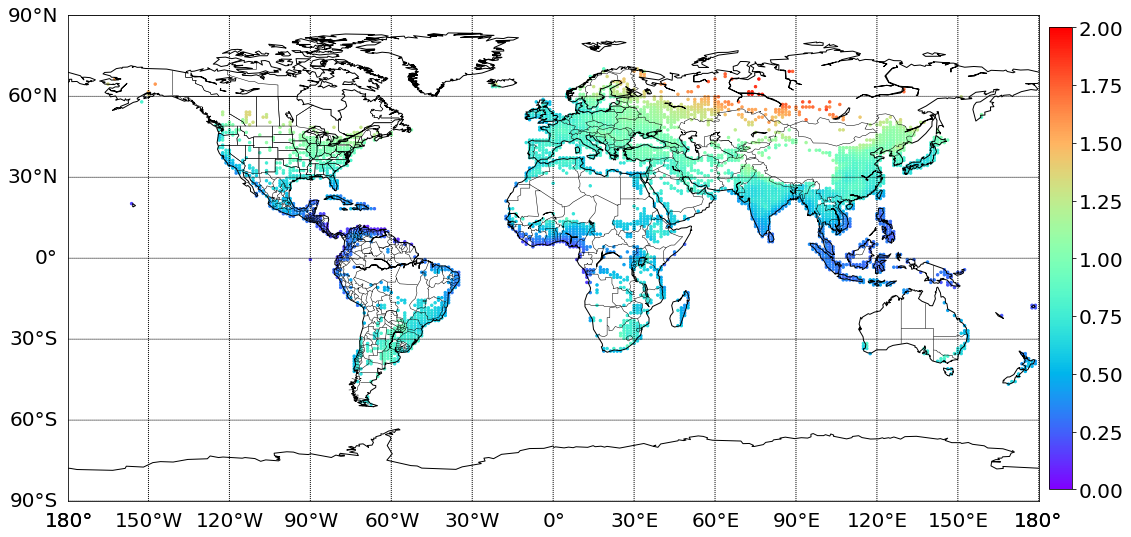

In [3]:
start_year="2006"
df_2006 = pd.read_csv(save_dir+start_year+"/rmse_by_lat_lon_mean.csv")
display(df_2006.describe())
global_map_plot(df_2006, "0", 0, 2, "rainbow","2006")

### 2061

,lat,lon,0
count,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,0.745279
std,25.646228,111.895429,0.285410
min,-54.188499,0.000000,0.100372
25%,8.952900,36.250000,0.545071
50%,29.685900,100.000000,0.760005
75%,42.879601,260.000000,0.931949
max,70.209396,358.750000,1.813340


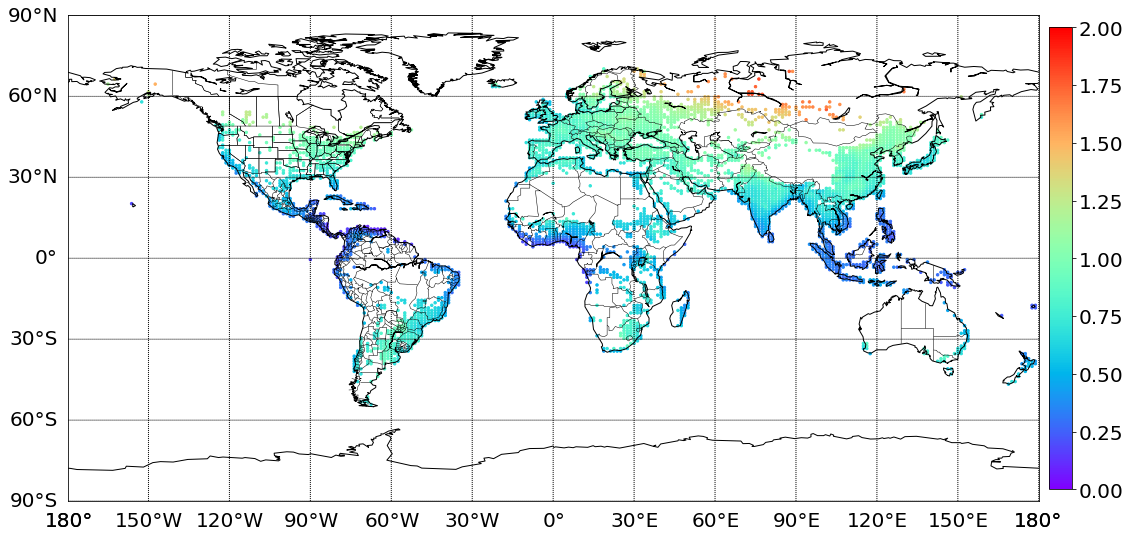

In [4]:
start_year="2061"
df_2061 = pd.read_csv(save_dir+start_year+"/rmse_by_lat_lon_mean.csv")
display(df_2061.describe())
global_map_plot(df_2061, "0", 0, 2, "rainbow","2061")

## r2_score

### 2006

,lat,lon,0
count,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,0.967457
std,25.646228,111.895429,0.038675
min,-54.188499,0.000000,0.737257
25%,8.952900,36.250000,0.963800
50%,29.685900,100.000000,0.983265
75%,42.879601,260.000000,0.989213
max,70.209396,358.750000,0.995750


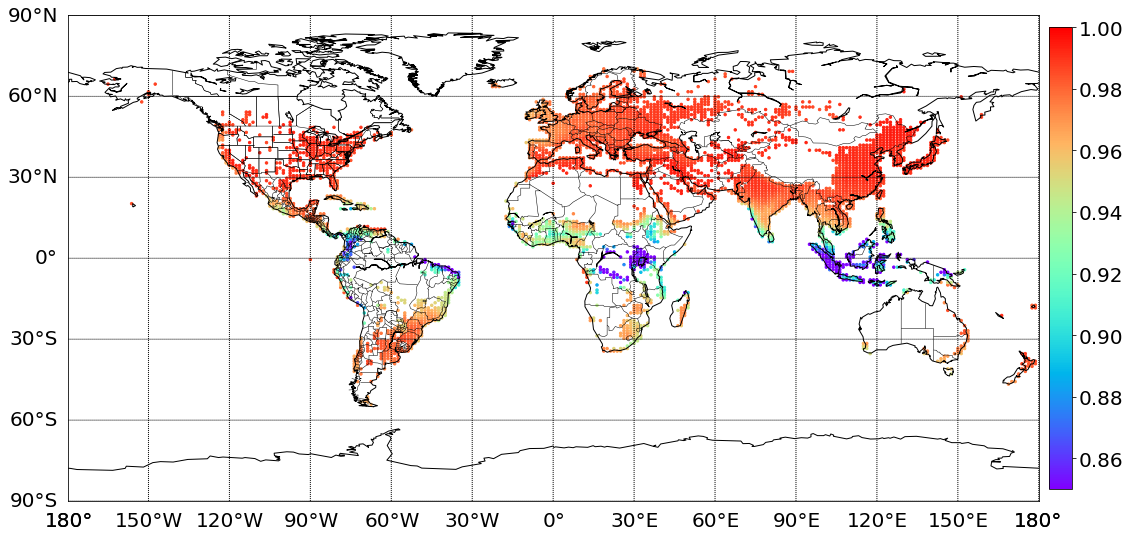

In [5]:
start_year="2006"
df_2006 = pd.read_csv(save_dir+start_year+"/pcc_by_lat_lon_mean.csv")
display(df_2006.describe())
global_map_plot(df_2006, "0", 0.85, 1, "rainbow","2006")

### 2061

,lat,lon,0
count,4439.000000,4439.000000,4439.000000
mean,23.864969,131.385729,0.967432
std,25.646228,111.895429,0.038738
min,-54.188499,0.000000,0.724923
25%,8.952900,36.250000,0.962422
50%,29.685900,100.000000,0.983531
75%,42.879601,260.000000,0.989725
max,70.209396,358.750000,0.995877


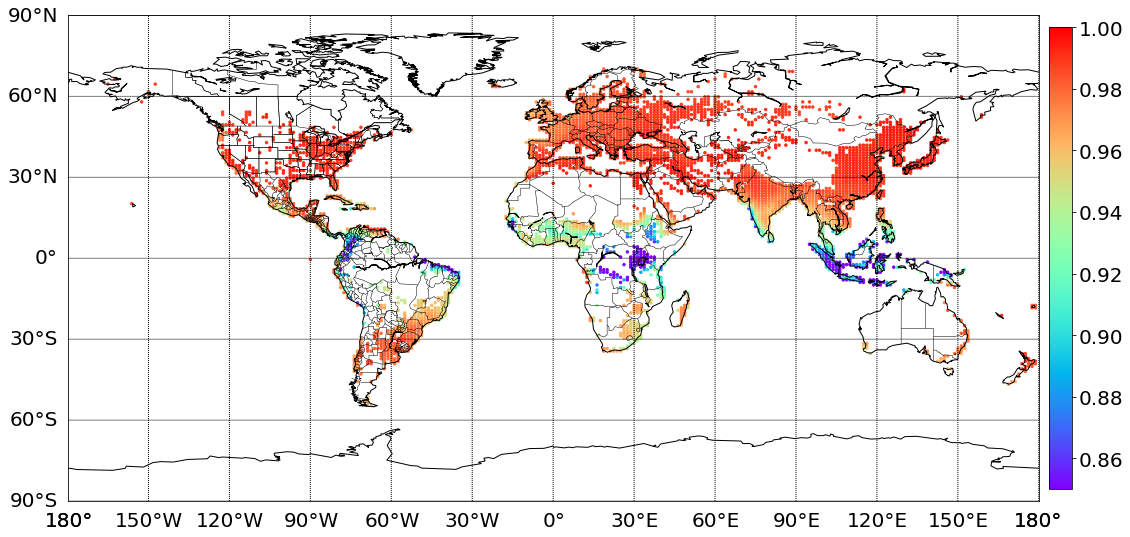

In [6]:
start_year="2061"
df_2006 = pd.read_csv(save_dir+start_year+"/pcc_by_lat_lon_mean.csv")
display(df_2006.describe())
global_map_plot(df_2006, "0", 0.85, 1, "rainbow","2061")